In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_sample_image

### Preparing the Dataset

In [2]:
BATCH_SIZE = 32
IMG_SIZE   = (128, 128)

percent_train = 0.7
percent_val   = 0.1
percent_test  = 0.2

IMAGES_DIR  = '../DatasetCleaning/'
SUBFOLDERS  = [ 'croppedface_no_mask', 'croppedface_with_mask', 'croppedface_with_mask_incorrect', 'croppedface_other_covering']
TYPE_DIRS   = { 
                'croppedface_other_covering': 'invalid', 
                'croppedface_with_mask': 'valid',
                'croppedface_no_mask': 'invalid', 
                'croppedface_with_mask_incorrect': 'valid' 
              }

In [3]:
usage_type_pairs = []

for subfolder in SUBFOLDERS:
    type_label  = TYPE_DIRS[subfolder]
    usage_label = subfolder[len('cropped'):]
    
    if usage_label == 'face_other_covering':
        usage_label = 'face_no_mask'
    
    class_name  = '{}, {}'.format(type_label, usage_label)
    usage_type_pairs += [ ('{}/{}'.format(subfolder, path), type_label, usage_label, class_name) for path in os.listdir(IMAGES_DIR + subfolder) ]

mask_dataset = pd.DataFrame(usage_type_pairs, columns = ['filename', 'usage', 'type', 'class'])
mask_train, mask_test = train_test_split(mask_dataset, test_size = percent_test)

mask_train, mask_test

(                                    filename    usage            type  \
 1948        croppedface_with_mask/132894.png    valid  face_with_mask   
 3883       croppedface_with_mask/3553124.png    valid  face_with_mask   
 3868       croppedface_with_mask/3532666.png    valid  face_with_mask   
 3571       croppedface_with_mask/3154580.png    valid  face_with_mask   
 6589  croppedface_other_covering/3135530.jpg  invalid    face_no_mask   
 ...                                      ...      ...             ...   
 6551  croppedface_other_covering/2973732.png  invalid    face_no_mask   
 2358       croppedface_with_mask/1733269.png    valid  face_with_mask   
 5551        croppedface_with_mask/854799.png    valid  face_with_mask   
 973          croppedface_no_mask/4386254.jpg  invalid    face_no_mask   
 1429          croppedface_no_mask/496242.jpg  invalid    face_no_mask   
 
                       class  
 1948  valid, face_with_mask  
 3883  valid, face_with_mask  
 3868  valid, fac

In [4]:
train_val_split = percent_val / (1 - percent_test)
mask_image_gen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255,
                                                                  validation_split = train_val_split)

In [5]:
train_ds = mask_image_gen.flow_from_dataframe(mask_train, directory = IMAGES_DIR, x_col = 'filename', y_col = 'class', 
                                              target_size = IMG_SIZE, subset = "training", batch_size  = BATCH_SIZE)

val_ds = mask_image_gen.flow_from_dataframe(mask_train, directory = IMAGES_DIR, x_col = 'filename', y_col = 'class', 
                                            target_size = IMG_SIZE, subset = "validation", batch_size= BATCH_SIZE)

test_ds = mask_image_gen.flow_from_dataframe(mask_test, directory = IMAGES_DIR, x_col = 'filename', y_col = 'class',
                                             target_size = IMG_SIZE, batch_size  = BATCH_SIZE)

Found 5082 validated image filenames belonging to 3 classes.
Found 726 validated image filenames belonging to 3 classes.
Found 1452 validated image filenames belonging to 3 classes.


### Usage and Type classifier

In [7]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.applications.ResNet50(include_top = False, input_shape = (*IMG_SIZE,3), pooling = 'max'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax'),
])
cnn_model.compile(optimizer = 'adam', loss = tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [9]:
history = cnn_model.fit(train_ds, validation_data = val_ds, epochs = 20)

Epoch 1/20
159/159 [==============================] - 67s 418ms/step - loss: 0.6790 - accuracy: 0.8062 - val_loss: 1.1486 - val_accuracy: 0.4022
Epoch 2/20
159/159 [==============================] - 18s 113ms/step - loss: 0.3154 - accuracy: 0.8884 - val_loss: 0.7242 - val_accuracy: 0.6970
Epoch 3/20
159/159 [==============================] - 18s 113ms/step - loss: 0.2349 - accuracy: 0.9126 - val_loss: 0.8696 - val_accuracy: 0.4022
Epoch 4/20
159/159 [==============================] - 18s 115ms/step - loss: 0.1963 - accuracy: 0.9301 - val_loss: 0.5845 - val_accuracy: 0.7039
Epoch 5/20
159/159 [==============================] - 18s 113ms/step - loss: 0.2668 - accuracy: 0.9054 - val_loss: 0.5056 - val_accuracy: 0.7961
Epoch 6/20
159/159 [==============================] - 18s 113ms/step - loss: 0.2062 - accuracy: 0.9250 - val_loss: 0.2976 - val_accuracy: 0.8912
Epoch 7/20
159/159 [==============================] - 18s 114ms/step - loss: 0.1228 - accuracy: 0.9524 - val_loss: 0.2920 - val_ac

In [12]:
results = cnn_model.evaluate(test_ds)

46/46 [==============================] - 4s 83ms/step - loss: 0.6476 - accuracy: 0.8698


In [11]:
print('Test loss: ', results[0])
print('Test acc: ', results[1])

Test loss:  0.6475803852081299
Test acc:  0.8698347210884094


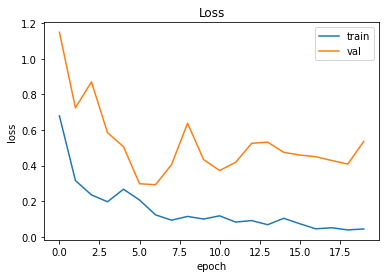

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

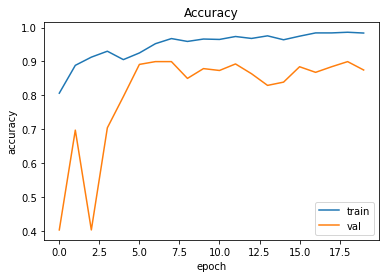

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()